# visualise_clustering.ipynb

The below plots demonstrate the clustering capabilities of PyPSA. **High spatial resolution is important to avoid information loss that make renewable investment expansion expensive**. For instance, in a high aggregated case, e.g. 1 node per country, the countries average wind potential can be used to optimise onshore wind power plants that can generate 2500 per year. If one would use the same wind potential in Nigeria but increase the spatial resolution, let's say to 50 nodes, one can observe that now high wind location are available which leads to the case that the same wind power plant can generate suddenly 5000h per year which saves costs. In an EU study, it was observed that using high resolved renewable can reduce the total system costs by 10\% [1] underlining the importance. Let's use then high resolution!

However, using high resolution can be computationally expensive. Setting in the `config.yaml` the `clusters` option does make the optimization problem quite big especially because the network constraints are quite heavy.
```python
clusters: [4, 14, 54]
```
Using the `simpl` option allows you to have high spatial resolution for renewables but reduce the network resolution making the optimization problem lean. 
```python
simpl: [54]
```

The below figures are created with the following config options:

```python
scenario:
  simpl: [54]
  ll: ['copt']
  clusters: [4, 14, 54]
  opts: [Co2L-12H]

countries: ["NG"]

snapshots:
  start: "2013-01-01"
  end: "2013-01-02"
  inclusive: "left" # end is not inclusive
```

Reference: 
[1] Frystacki et al. (2021). The strong effect of network resolution on electricity system models with high shares of wind and solar. Applied Energy. https://www.sciencedirect.com/science/article/pii/S0306261921002439

In [1]:
import pypsa
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# customize your plot
resolutions = [4, 14, 54]  # must be 3 numbers
plot_capfacs = (
    "onwind"  # colors in the back represent capacity factors for this technology
)
cmap = "Blues"  # colormap for upper technology
red_linewidth = 3
red_bussizes = 5e-2

INFO:pypsa.io:Imported network elec_s54_4.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s54_14.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s54_54.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s54_4.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s54_4.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s54_14.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s54_54.nc has buses, carriers, generators, lines, loads, storage_units


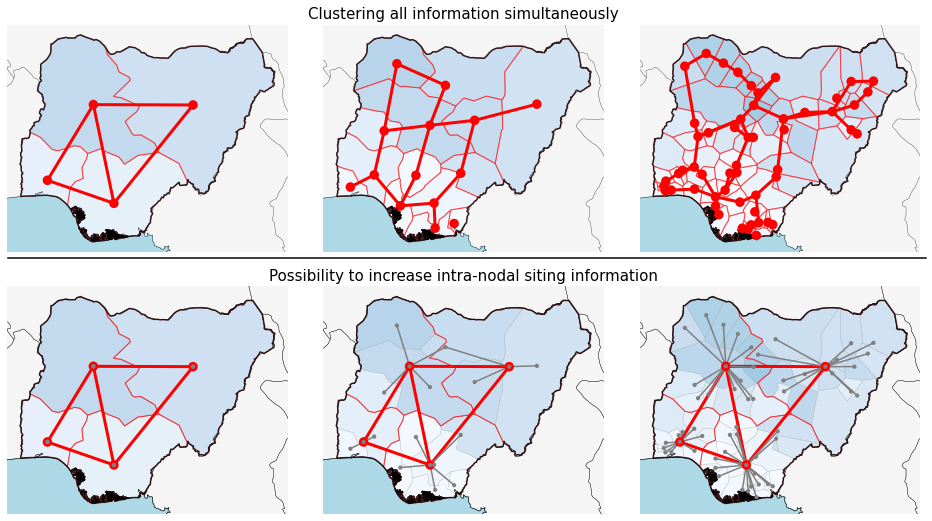

In [3]:
fig, axes = plt.subplots(
    2, 3, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(17, 9)
)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.15)

country = gpd.read_file("../resources/country_shapes.geojson")

c = 0
for ax in axes[0, :]:
    n = pypsa.Network(f"../networks/elec_s54_{resolutions[c]}.nc")
    r = gpd.read_file(
        f"../resources/regions_onshore_elec_s54_{resolutions[c]}.geojson"
    ).set_index("name")
    factor = n.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
    factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
    r["factor"] = factor

    n.plot(
        color_geomap=True,
        bus_colors="red",
        bus_sizes=red_bussizes,
        line_colors="red",
        line_widths=red_linewidth,
        ax=ax,
    )
    r.boundary.plot(ax=ax, color="red", linewidth=1, alpha=0.5)
    r.plot(ax=ax, column="factor", cmap=cmap, alpha=1, vmin=0, vmax=1)
    country.boundary.plot(ax=ax, color="black", alpha=0.75)
    c += 1

c = 0
n = pypsa.Network(f"../networks/elec_s54_4.nc")
r = gpd.read_file(f"../resources/regions_onshore_elec_s54_4.geojson").set_index("name")
b = pd.read_csv("../resources/busmap_elec_s54_4.csv", index_col=0).squeeze("columns")

for ax in axes[1, :]:
    n2 = pypsa.Network(f"../networks/elec_s54_{resolutions[c]}.nc")
    r2 = gpd.read_file(
        f"../resources/regions_onshore_elec_s54_{resolutions[c]}.geojson"
    ).set_index("name")
    factor = n2.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
    factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
    r2["factor"] = factor

    b2 = pd.read_csv(
        f"../resources/busmap_elec_s54_{resolutions[c]}.csv", index_col=0
    ).squeeze("columns")
    n2.mremove("Line", n2.lines.index)

    debug = 0
    for nb in b.unique():
        nl = b2.loc[b[b == nb].index].unique()
        nb = n.buses.loc[nb]
        nb.name = nb.name + " ref"
        n2.madd("Bus", names=[nb.name], x=nb.x, y=nb.y)
        n2.madd(
            "Line", names=nl + f" ref line {debug}", bus0=[nb.name] * len(nl), bus1=nl
        )

        debug += 1

    n.plot(
        color_geomap=True,
        bus_colors="red",
        bus_sizes=red_bussizes,
        line_colors="red",
        line_widths=red_linewidth,
        ax=ax,
    )
    n2.plot(bus_colors="grey", bus_sizes=1e-2, line_colors="grey", ax=ax)
    r2.boundary.plot(ax=ax, color="grey", linewidth=0.25, alpha=0.5)
    r2.plot(ax=ax, column="factor", cmap=cmap, alpha=1, vmin=0, vmax=1)
    r.boundary.plot(ax=ax, color="red", linewidth=1, alpha=0.5)
    country.boundary.plot(ax=ax, color="black", alpha=0.75)

    c += 1

axes[0, 1].set_title(
    "Clustering all information simultaneously", fontsize=15
)  # , FontWeight = 'bold')
axes[1, 1].set_title(
    "Possibility to increase intra-nodal siting information", fontsize=15
)  # , FontWeight = 'bold')

# Draw a horizontal line
line = plt.Line2D([0.14, 0.89], [0.52, 0.52], transform=fig.transFigure, color="black")
fig.add_artist(line)

# plt.savefig("visualise_clustering.pdf", bbox_inches="tight")
plt.show()